This notebook generates NME, AUC, and CED curves for five 3DFA methods. Parts of the codes have been written with the help of this repository: https://github.com/thanhhvnqb/3dface_val

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import time
import sys
import os
from os import listdir, makedirs
from os.path import isfile, join, isdir
import pickle
import gzip

import numpy as np
import matplotlib.pylab as plt
import matplotlib
import scipy.io as sio
from tqdm import tqdm


# 3D bounding box computation
def getBBsize3D(points):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    bbsize = maxs - mins
    normby = np.sqrt(bbsize[0] * bbsize[1] * bbsize[2])
    return np.sqrt(bbsize[0] * bbsize[1] * bbsize[2])

# 2D bounding box computation
def getBBsize2D(points):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    bbsize = maxs - mins
    normby = np.sqrt(bbsize[0] * bbsize[1])
    return np.sqrt(bbsize[0] * bbsize[1])

# normalization distance between eyes' centers
def getNormDist(points):
    left_eye_inds = np.arange(36,42)
    right_eye_inds = np.arange(42,48)
    # compute the distance between the two eyes as a normalization constant
    p1 = np.mean(points[left_eye_inds, :], axis = 0)
    p2 = np.mean(points[right_eye_inds, :], axis = 0)
    normalization_dist = np.sqrt(np.sum((p1 - p2)*(p1 - p2)));
    return normalization_dist
    
# 3D distance computation with bounding box normalization
def calcDistance3D(pred, gt_pts):
    bbsize = getBBsize3D(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / bbsize

# 3D distance computation with bounding box normalization + centering of z coordinates
def calcDistance3Dminus(pred, gt_pts):
    pred[:,2] -= np.mean(pred[:,2])
    gt_pts[:,2] -= np.mean(gt_pts[:,2])    
    bbsize = getBBsize3D(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / bbsize

# 2D distance computation with bounding box normalization
def calcDistance2D(pred, gt_pts):
    bbsize = getBBsize2D(gt_pts[:,:2])
    return np.linalg.norm(pred[:,:2] - gt_pts[:,:2], axis=1) / bbsize

# 2D distance computation with eyes' distance normalization
def calcDistanceE2D(pred, gt_pts):
    norm_dist = getNormDist(gt_pts[:,:2])
    return np.linalg.norm(pred[:,:2] - gt_pts[:,:2], axis=1) / norm_dist

# 3D distance computation with eyes' distance normalization
def calcDistanceE3D(pred, gt_pts):
    norm_dist = getNormDist(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / norm_dist

# 3D distance computation with eyes' distance normalization + centering of z coordinates
def calcDistanceE3Dminus(pred, gt_pts):
    pred[:,2] -= np.mean(pred[:,2])
    gt_pts[:,2] -= np.mean(gt_pts[:,2])
    norm_dist = getNormDist(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / norm_dist

# calculating distance per face (averaging error over 68 landmarks for each face) - bounding box normalization
def calculateMetrics(dists, error_np):
    errors = np.mean(dists, axis=0)
    np.save(error_np, errors)
    axes1 = np.linspace(0, 1, 1000)
    axes2 = np.zeros(1000)
    for i in range(1000):
        axes2[i] = (errors < axes1[i]).sum() / float(errors.shape[0])
    auc = np.sum(axes2[:70]) / 70
    ced = axes2
    return auc, np.mean(errors), np.std(errors)/np.sqrt(float(errors.shape[0])), ced

# calculating distance per face (averaging error over 68 landmarks for each face) - eyes distance normalization
def calculateMetricsE(dists, error_np):
    errors = np.mean(dists, axis=0)
    np.save(error_np, errors)
    axes1 = np.linspace(0, 1, 1000)
    axes2 = np.zeros(1000)
    for i in range(1000):
        axes2[i] = (errors < axes1[i]).sum() / float(errors.shape[0])
    auc = np.sum(axes2[:500]) / 500
    ced = axes2
    return auc, np.mean(errors), np.std(errors)/np.sqrt(float(errors.shape[0])), ced

# calculating distance per landmark "before" averaging - bounding box normalization
def calculateMetricsProp(dists, error_np):
    errors = np.mean(dists, axis=0)
    np.save(error_np, dists)
    axes1 = np.linspace(0, 1, 1000)
    axes2 = np.zeros(1000)
    for i in range(1000):
        acc_all = np.mean(dists > axes1[i], axis = 0)
        axes2[i] = (acc_all < axes1[i]).sum() / float(errors.shape[0])
    auc = np.sum(axes2[:70]) / 70
    ced = axes2
    return auc, np.mean(errors), np.std(errors)/np.sqrt(float(errors.shape[0])), ced

# calculating distance per landmark "before" averaging - eyes distance normalization
def calculateMetricsEProp(dists, error_np):
    errors = np.mean(dists, axis=0)
    np.save(error_np, dists)
    axes1 = np.linspace(0, 1, 1000)
    axes2 = np.zeros(1000)
    for i in range(1000):
        acc_all = np.mean(dists > axes1[i], axis = 0)
        axes2[i] = (acc_all < axes1[i]).sum() / float(errors.shape[0])
    auc = np.sum(axes2[:300]) / 300
    ced = axes2
    return auc, np.mean(errors), np.std(errors)/np.sqrt(float(errors.shape[0])), ced


## First obtain the list of good-for-all files

In [6]:
# This is to remove those face images for which some of the algorithms totally fail. In this case, 3DDFA is the worst
# in terms of detecting the face and/or detecting the landmarks
db_eval = {
    '3DDFA': "./results/ldks_3DDFA",
}

In [11]:
# AFLW20003D dataset
# Normalized distance = bounding boxes

gts_dir = './AFLW2000'

aucs, mean_nmes, std_nmes = dict(), dict(), dict()

for dbkey, folder in db_eval.items():
    
    len_list = 0
    
    preds_dir = db_eval[dbkey]
    
    files_list = [os.path.join(root, name)
     for root, dirs, files in os.walk(preds_dir)
     for name in files
     if name.endswith('.txt')]
    
    dists = None
    
    good_files = []
    
    for pts_file in files_list:

        # load predicted landmarks
        preds = np.loadtxt(pts_file)
        if dbkey == '2DASL' or dbkey == '3DDFA':
            preds = preds.T
            
        if len(preds):
            
            good_files.append(os.path.basename(pts_file)[:-4])
            
            len_list += 1
            # load ground truth landmarks
            if dbkey != 'Bulat':
                pts_gt_file = gts_dir + '/' + os.path.basename(pts_file)[:-4]+".mat"
            else:
                pts_gt_file = gts_dir + '/' + os.path.basename(pts_file)[:-8]+".mat"

            gts_i = sio.loadmat(pts_gt_file)['pt3d_68']
            gts_i = gts_i.T

            dist = calcDistance3D(preds, gts_i)
            dist = dist.reshape((68, 1))

            if dists is None:
                dists = dist
            else:
                dists = np.append(dists, dist, axis=1)


    scores = dists
    aucs[dbkey], mean_nmes[dbkey], std_nmes[dbkey], _ = calculateMetrics(dists, error_np = preds_dir + '/%s_3D.npy' % dbkey)   

    print('***** {} **** finished *** {}'.format(dbkey, len_list))

***** 3DDFA **** finished *** 1510


In [ ]:
db_eval = {
    '3DDFA_V2': '../results/AFLW20003D/3DDFA_V2',
    'Bulat': '../results/ldks_Bulat',
    'PRNet': "../results/ldks_PRNET",
    '2DASL': "../results/ldks_2DASL",
    '3DDFA': "../results/ldks_3DDFA",
}

In [52]:
# AFLW20003D dataset
# Normalized distance = bounding boxes

gts_dir = './AFLW2000'

aucs, mean_nmes, std_nmes = dict(), dict(), dict()

for dbkey, folder in db_eval.items():
    
    len_list = 0
    
    preds_dir = db_eval[dbkey]
    
    files_list = [os.path.join(root, name)
     for root, dirs, files in os.walk(preds_dir)
     for name in files
     if name.endswith('.txt')]
    
    dists = None

    for pts_file in files_list:

        # load predicted landmarks
        preds = np.loadtxt(pts_file)
        if dbkey == '2DASL' or dbkey == '3DDFA':
            preds = preds.T
            
        if len(preds):
            
            len_list += 1
            # load ground truth landmarks
            if dbkey != 'Bulat':
                pts_gt_file = gts_dir + '/' + os.path.basename(pts_file)[:-4]+".mat"
            else:
                pts_gt_file = gts_dir + '/' + os.path.basename(pts_file)[:-8]+".mat"

            gts_i = sio.loadmat(pts_gt_file)['pt3d_68']
            gts_i = gts_i.T

            dist = calcDistance3D(preds, gts_i)
            dist = dist.reshape((68, 1))

            if dists is None:
                dists = dist
            else:
                dists = np.append(dists, dist, axis=1)


    scores = dists
    aucs[dbkey], mean_nmes[dbkey], std_nmes[dbkey], _ = calculateMetrics(dists, error_np = preds_dir + '/%s_3D.npy' % dbkey)   

    print('***** {} **** finished *** {}'.format(dbkey, len_list))

***** 3DDFA_V2 **** finished *** 1964
***** Bulat **** finished *** 1997
***** PRNet **** finished *** 1976
***** 2DASL **** finished *** 1998
***** 3DDFA **** finished *** 1510


In [53]:
str_format = "%25s | %5.2f |   %5.2f  | %5.2f"
print("%25s |  AUC  | Mean NME | StD NME" % "Dataset")
for dbkey in db_eval.keys():
    print(str_format %(dbkey, aucs[dbkey] * 100, mean_nmes[dbkey] * 100, std_nmes[dbkey] * 100))

                  Dataset |  AUC  | Mean NME | StD NME
                 3DDFA_V2 | 37.56 |    4.34  |  0.97
                    Bulat | 90.06 |    0.65  |  0.77
                    PRNet | 15.20 |    5.98  |  0.94
                    2DASL | 62.78 |    2.56  |  1.03
                    3DDFA | 50.28 |    3.45  |  0.97


In [14]:
db_eval = {
    '3DDFA_V2': './results/AFLW20003D/3DDFA_V2',
    'Bulat': './results/ldks_Bulat',
    'PRNet': "./results/ldks_PRNET",
    '2DASL': "./results/ldks_2DASL",
    '3DDFA': "./results/ldks_3DDFA",
}

In [28]:
# AFLW20003D dataset
# Normalized distance = distance between eyes

gts_dir = '/srv/storage/talc@talc-data.nancy/multispeech/corpus/FaceData/AFLW2000'

aucs, mean_nmes, std_nmes = dict(), dict(), dict()

for dbkey, folder in db_eval.items():
    
    preds_dir = db_eval[dbkey]
    
    dists = None

    for pts_file_name in good_files:

        if dbkey != 'Bulat':
            pts_file = os.path.join(preds_dir, pts_file_name+'.txt')
        else:
            pts_file = os.path.join(preds_dir, pts_file_name+'.jpg.txt')
        
        if os.path.isfile(pts_file):
            
            # load predicted landmarks
            preds = np.loadtxt(pts_file)
            if dbkey == '2DASL' or dbkey == '3DDFA':
                preds = preds.T

            if len(preds):

                # load ground truth landmarks
                if dbkey != 'Bulat':
                    pts_gt_file = gts_dir + '/' + os.path.basename(pts_file)[:-4]+".mat"
                else:
                    pts_gt_file = gts_dir + '/' + os.path.basename(pts_file)[:-8]+".mat"

                gts_i = sio.loadmat(pts_gt_file)['pt3d_68']
                gts_i = gts_i.T

                dist = calcDistanceE2D(preds, gts_i)
                dist = dist.reshape((68, 1))

                if dists is None:
                    dists = dist
                else:
                    dists = np.append(dists, dist, axis=1)


    scores = dists
    aucs[dbkey], mean_nmes[dbkey], std_nmes[dbkey], _ = calculateMetricsEProp(dists, error_np = preds_dir + '/%s_DistEyes_3DminusProp.npy' % dbkey)   

    print('***** {} **** finished *** {}'.format(dbkey, len_list))

***** 3DDFA_V2 **** finished *** 1510
***** Bulat **** finished *** 1510
***** PRNet **** finished *** 1510
***** 2DASL **** finished *** 1510
***** 3DDFA **** finished *** 1510


In [29]:
str_format = "%25s | %5.2f |   %5.2f  | %5.2f"
print("%25s |  AUC  | Mean NME | StD NME" % "Dataset")
for dbkey in db_eval.keys():
    print(str_format %(dbkey, aucs[dbkey] * 100, mean_nmes[dbkey] * 100, std_nmes[dbkey] * 100))

                  Dataset |  AUC  | Mean NME | StD NME
                 3DDFA_V2 | 55.73 |   10.18  |  0.76
                    Bulat | 58.24 |    9.84  |  0.95
                    PRNet | 57.48 |    9.22  |  0.64
                    2DASL | 35.84 |   31.24  |  1.07
                    3DDFA | 56.50 |   14.87  |  1.67


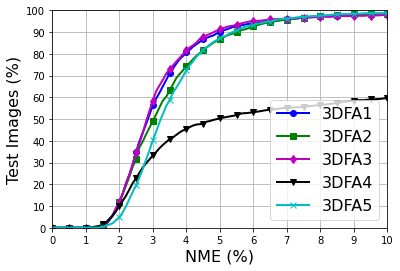

In [22]:
import os
import matplotlib
%matplotlib inline
import pylab as plt
import numpy as np

if not os.path.isdir('./results/NME_plot'):
    os.makedirs('./results/NME_plot')

dataset = 'AFLW20003D'

name_base = 10

errors_2dasl = np.load('./results/ldks_2DASL/2DASL_2D.npy')
errors_3ddfa = np.load('./results/ldks_3DDFA/3DDFA_2D.npy')
errors_bulat = np.load('./results/ldks_Bulat/Bulat_2D.npy')
errors_3ddfa_v2 = np.load('./results/AFLW20003D/3DDFA_V2/3DDFA_V2_2D.npy')
errors_prnet = np.load('./results/ldks_PRNET/PRNet_2D.npy')

axes1 = np.linspace(0, 1, 1000)
axes2_2dasl = np.zeros(1000)
axes2_3ddfa = np.zeros(1000)
axes2_bulat = np.zeros(1000)
axes2_3ddfa_v2 = np.zeros(1000)
axes2_prnet = np.zeros(1000)

f = plt.figure()
for i in range(1000):
    axes2_2dasl[i] = (errors_2dasl < axes1[i]).sum() / float(errors_2dasl.shape[0])
    axes2_3ddfa[i] = (errors_3ddfa < axes1[i]).sum() / float(errors_3ddfa.shape[0])
    axes2_bulat[i] = (errors_bulat < axes1[i]).sum() / float(errors_bulat.shape[0])
    axes2_3ddfa_v2[i] = (errors_3ddfa_v2 < axes1[i]).sum() / float(errors_3ddfa_v2.shape[0])
    axes2_prnet[i] = (errors_prnet < axes1[i]).sum() / float(errors_prnet.shape[0])

mks = 6
mk_eve = 5
plt.xlim(0, name_base)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.xticks(np.arange(0,name_base+1,1))
plt.grid()
plt.xlabel('NME (%)', fontsize=16)
plt.ylabel('Test Images (%)', fontsize=16)
plt.plot(axes1*100,axes2_bulat*100,'-bo',label='3DFA1', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_prnet*100,'-gs',label='3DFA2', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_3ddfa*100,'-md',label='3DFA3', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_2dasl*100,'-kv',label='3DFA4', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_3ddfa_v2*100,'-cx',label='3DFA5', markersize = mks, markevery=mk_eve, lw=2)

plt.legend(loc=4, fontsize=16)
plt.savefig('./results/NME_plot/' + dataset + '_2D.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

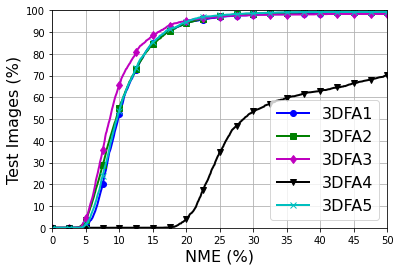

In [29]:
import os
import matplotlib
%matplotlib inline
import pylab as plt
import numpy as np

if not os.path.isdir('./results/NME_plot'):
    os.makedirs('./results/NME_plot')

dataset = 'AFLW20003D'

name_base = 50

errors_2dasl = np.load('./results/ldks_2DASL/2DASL_DistEyes_3Dminus.npy')
errors_3ddfa = np.load('./results/ldks_3DDFA/3DDFA_DistEyes_3Dminus.npy')
errors_bulat = np.load('./results/ldks_Bulat/Bulat_DistEyes_3Dminus.npy')
errors_3ddfa_v2 = np.load('./results/AFLW20003D/3DDFA_V2/3DDFA_V2_DistEyes_3Dminus.npy')
errors_prnet = np.load('./results/ldks_PRNET/PRNet_DistEyes_3Dminus.npy')

axes1 = np.linspace(0, 1, 1000)
axes2_2dasl = np.zeros(1000)
axes2_3ddfa = np.zeros(1000)
axes2_bulat = np.zeros(1000)
axes2_3ddfa_v2 = np.zeros(1000)
axes2_prnet = np.zeros(1000)

f = plt.figure()
for i in range(1000):
    axes2_2dasl[i] = (errors_2dasl < axes1[i]).sum() / float(errors_2dasl.shape[0])
    axes2_3ddfa[i] = (errors_3ddfa < axes1[i]).sum() / float(errors_3ddfa.shape[0])
    axes2_bulat[i] = (errors_bulat < axes1[i]).sum() / float(errors_bulat.shape[0])
    axes2_3ddfa_v2[i] = (errors_3ddfa_v2 < axes1[i]).sum() / float(errors_3ddfa_v2.shape[0])
    axes2_prnet[i] = (errors_prnet < axes1[i]).sum() / float(errors_prnet.shape[0])

mks = 6
mk_eve = 25
plt.xlim(0, name_base)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.xticks(np.arange(0,name_base+1,5))
plt.grid()
plt.xlabel('NME (%)', fontsize=16)
plt.ylabel('Test Images (%)', fontsize=16)
plt.plot(axes1*100,axes2_bulat*100,'-bo',label='3DFA1', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_prnet*100,'-gs',label='3DFA2', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_3ddfa*100,'-md',label='3DFA3', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_2dasl*100,'-kv',label='3DFA4', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_3ddfa_v2*100,'-cx',label='3DFA5', markersize = mks, markevery=mk_eve, lw=2)

plt.legend(loc=4, fontsize=16)
plt.savefig('./results/NME_plot/' + dataset + '_DistEyes_3Dminus.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

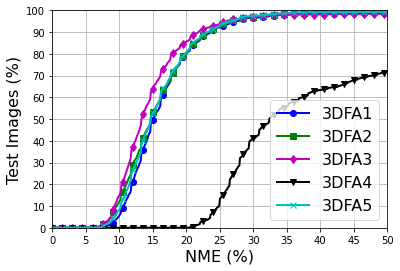

In [49]:
# plots according to the proposed, per-landmark error computation
import os
import matplotlib
%matplotlib inline
import pylab as plt
import numpy as np

if not os.path.isdir('./results/NME_plot'):
    os.makedirs('./results/NME_plot')

dataset = 'AFLW20003D'

name_base = 50

errors_2dasl = np.load('./results/ldks_2DASL/2DASL_DistEyes_3DminusProp.npy') #DistEyes_
errors_3ddfa = np.load('./results/ldks_3DDFA/3DDFA_DistEyes_3DminusProp.npy')
errors_bulat = np.load('./results/ldks_Bulat/Bulat_DistEyes_3DminusProp.npy')
errors_3ddfa_v2 = np.load('./results/AFLW20003D/3DDFA_V2/3DDFA_V2_DistEyes_3DminusProp.npy')
errors_prnet = np.load('./results/ldks_PRNET/PRNet_DistEyes_3DminusProp.npy')

axes1 = np.linspace(0, 1, 1000)
axes2_2dasl = np.zeros(1000)
axes2_3ddfa = np.zeros(1000)
axes2_bulat = np.zeros(1000)
axes2_3ddfa_v2 = np.zeros(1000)
axes2_prnet = np.zeros(1000)

f = plt.figure()
for i in range(1000):
    acc_all_2dasl = 1. - np.mean(errors_2dasl < axes1[i], axis = 0)
    acc_all_3ddfa = 1. - np.mean(errors_3ddfa < axes1[i], axis = 0)
    acc_all_bulat = 1. - np.mean(errors_bulat < axes1[i], axis = 0)
    acc_all_3ddfa_v2 = 1. - np.mean(errors_3ddfa_v2 < axes1[i], axis = 0)
    acc_all_prnet = 1. - np.mean(errors_prnet < axes1[i], axis = 0)
    axes2_2dasl[i] = (acc_all_2dasl < axes1[i]).sum() / float(errors_2dasl.shape[1])
    axes2_3ddfa[i] = (acc_all_3ddfa < axes1[i]).sum() / float(errors_3ddfa.shape[1])
    axes2_bulat[i] = (acc_all_bulat < axes1[i]).sum() / float(errors_bulat.shape[1])
    axes2_3ddfa_v2[i] = (acc_all_3ddfa_v2 < axes1[i]).sum() / float(errors_3ddfa_v2.shape[1])
    axes2_prnet[i] = (acc_all_prnet < axes1[i]).sum() / float(errors_prnet.shape[1])
  
mks = 6
mk_eve = 15
plt.xlim(0, name_base)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.xticks(np.arange(0,name_base+1,5))
plt.grid()
#plt.title('NME (%)', fontsize=20)
plt.xlabel('NME (%)', fontsize=16)
plt.ylabel('Test Images (%)', fontsize=16)
plt.plot(axes1*100,axes2_bulat*100,'-bo',label='3DFA1', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_prnet*100,'-gs',label='3DFA2', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_3ddfa*100,'-md',label='3DFA3', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_2dasl*100,'-kv',label='3DFA4', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(axes1*100,axes2_3ddfa_v2*100,'-cx',label='3DFA5', markersize = mks, markevery=mk_eve, lw=2)

plt.legend(loc=4, fontsize=16)
# plt.show()
plt.savefig('../results/NME_plot/' + dataset + '_DistEyes_3DminusProp.pdf', transparent=True, bbox_inches='tight', pad_inches=0) #DistEyes_